In [165]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier as rfc
from scipy.ndimage import gaussian_filter
%matplotlib inline

/astro/store/epyc/opt/lsst/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Make training set

### False Dataset

Our false data is a set of postage stamps actually collected from KBMOD that were false positives coming through the pipeline.

In [2]:
full_false = np.load('/epyc/users/smotherh/kbmod_epyc/notebooks/stamp_training_set.npy')

In [7]:
train_false = full_false[:40000]

In [8]:
test_false = full_false[40000:]

In [9]:
len(train_false), len(test_false)

(40000, 10005)

In [10]:
np.shape(train_false[0])

(21, 21)

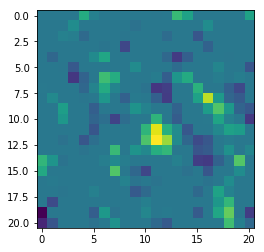

In [283]:
plt.imshow(train_false[5000])

### Make real dataset

Make some real Gaussians and add noise to use as truth for training.

In [301]:
full_true = []
rand_state = np.random.RandomState(444)
for i in range(50005):
    x_true = np.zeros((21, 21))
    x_true[10,10] = 1.
    x_true += rand_state.normal(0., 0.08, size=(21,21))
    x_gauss = gaussian_filter(x_true, 1.4)
    x_true += rand_state.normal(0., 0.05, size=(21,21))
    full_true.append(x_gauss)

In [302]:
train_true = full_true[:40000]
test_true = full_true[40000:]

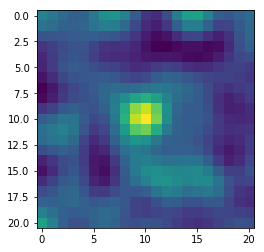

In [320]:
plt.imshow(train_true[1890])

### Merge true and false into full training and test sets

In [321]:
train_set = []
rand_state = np.random.RandomState(1302)
rand_idx = np.arange(80000)
rand_state.shuffle(rand_idx)
train_class = []
for idx in rand_idx:
    if idx < 40000:
        train_set.append(train_false[idx].flatten())
        train_class.append(0)
    else:
        train_set.append(train_true[idx-40000].flatten())
        train_class.append(1)

In [322]:
test_set = []
rand_idx = np.arange(20010)
rand_state.shuffle(rand_idx)
test_class = []
for idx in rand_idx:
    if idx < 10005:
        test_set.append(test_false[idx].flatten())
        test_class.append(0)
    else:
        test_set.append(test_true[idx-10005].flatten())
        test_class.append(1)

## Train Classifier

In [323]:
rand_rfc_state = np.random.RandomState(345)
rfc_kbmod = rfc(n_estimators=100, random_state=rand_rfc_state)

In [324]:
rfc_kbmod.fit(train_set, train_class)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False,
            random_state=<mtrand.RandomState object at 0x7fc4a45d2708>,
            verbose=0, warm_start=False)

In [325]:
test_results = rfc_kbmod.predict(test_set)

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.9939e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.9000e+01]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

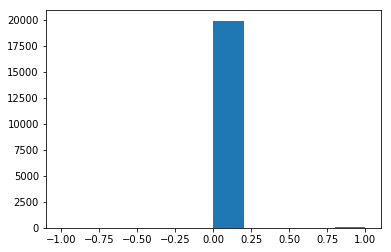

In [326]:
plt.hist(test_class - test_results)

In [333]:
test_probs = rfc_kbmod.predict_proba(test_set)

In [398]:
fpr = []
tpr = []
for cutoff in np.arange(0.01, 1.0, 0.01):
    correct_false = []
    correct_true = []
    false_positive = []
    false_negative = []
    index = 0
    for true_class, result_prob in zip(test_class, test_probs):
        if true_class == 0.:
            if result_prob[0] > cutoff:
                correct_false.append(index)
            else:
                false_positive.append(index)
        else:
            if result_prob[0] > cutoff:
                false_negative.append(index)
            else:
                correct_true.append(index)
        index+=1
    fpr.append(len(false_positive)/10005)
    tpr.append(len(correct_true)/10005)

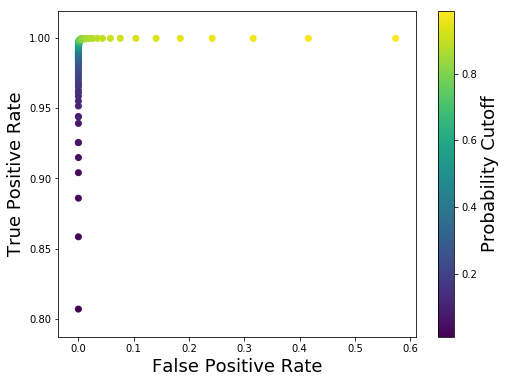

In [399]:
fig = plt.figure(figsize=(8,6))
plt.scatter(fpr, tpr, c=np.arange(0.01, 1.0, 0.01))
cbar = plt.colorbar()
plt.xlabel('False Positive Rate', size=18)
plt.ylabel('True Positive Rate', size=18)
cbar.set_label('Probability Cutoff', size=18)

If we set our cutoff to 0.89 we don't lose any trues. Let's see how this performs

In [403]:
correct_false = []
correct_true = []
false_positive = []
false_negative = []
index = 0
cutoff = 0.89
for true_class, result_prob in zip(test_class, test_probs):
    if true_class == 0.:
        if result_prob[0] > cutoff:
            correct_false.append(index)
        else:
            false_positive.append(index)
    else:
        if result_prob[0] > cutoff:
            false_negative.append(index)
        else:
            correct_true.append(index)
    index+=1

In [404]:
57/10005

0.005697151424287856

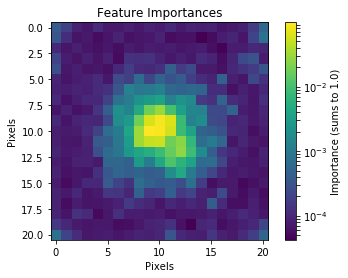

In [405]:
plt.imshow(rfc_kbmod.feature_importances_.reshape(21,21), norm=mpl.colors.LogNorm())
cbar = plt.colorbar()
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.title('Feature Importances')
cbar.set_label('Importance (sums to 1.0)')

In [406]:
test_total = np.array([test_class, test_results]).T

In [407]:
results_df = pd.DataFrame(test_total, columns=['True Class', 'Predicted Class'])

In [408]:
rfc_results = np.array([[len(correct_true), len(false_positive)], [len(false_negative), len(correct_false)]])

([<matplotlib.axis.YTick at 0x7fc49f52ef98>,
 <a list of 2 Text yticklabel objects>)

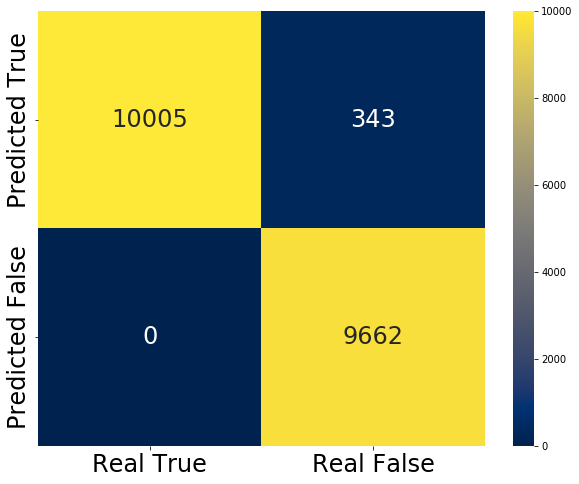

In [409]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(rfc_results, annot=True, annot_kws={'size':24}, cmap=plt.get_cmap('cividis'), fmt='g')
plt.xticks([0.5, 1.5], ['Real True', 'Real False'], size=24)
plt.yticks([0.5, 1.5], ['Predicted True', 'Predicted False'], size=24, va='center')

### Look at False Negatives and False Positives

IndexError: list index out of range

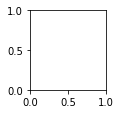

In [412]:
fig = plt.figure(figsize=(16, 12))
for i in range(69):
    fig.add_subplot(7, 10, i+1)
    plt.imshow(test_set[false_negative[i]].reshape(21,21))
    plt.title(test_probs[false_negative[i]])
plt.suptitle('False Negatives')

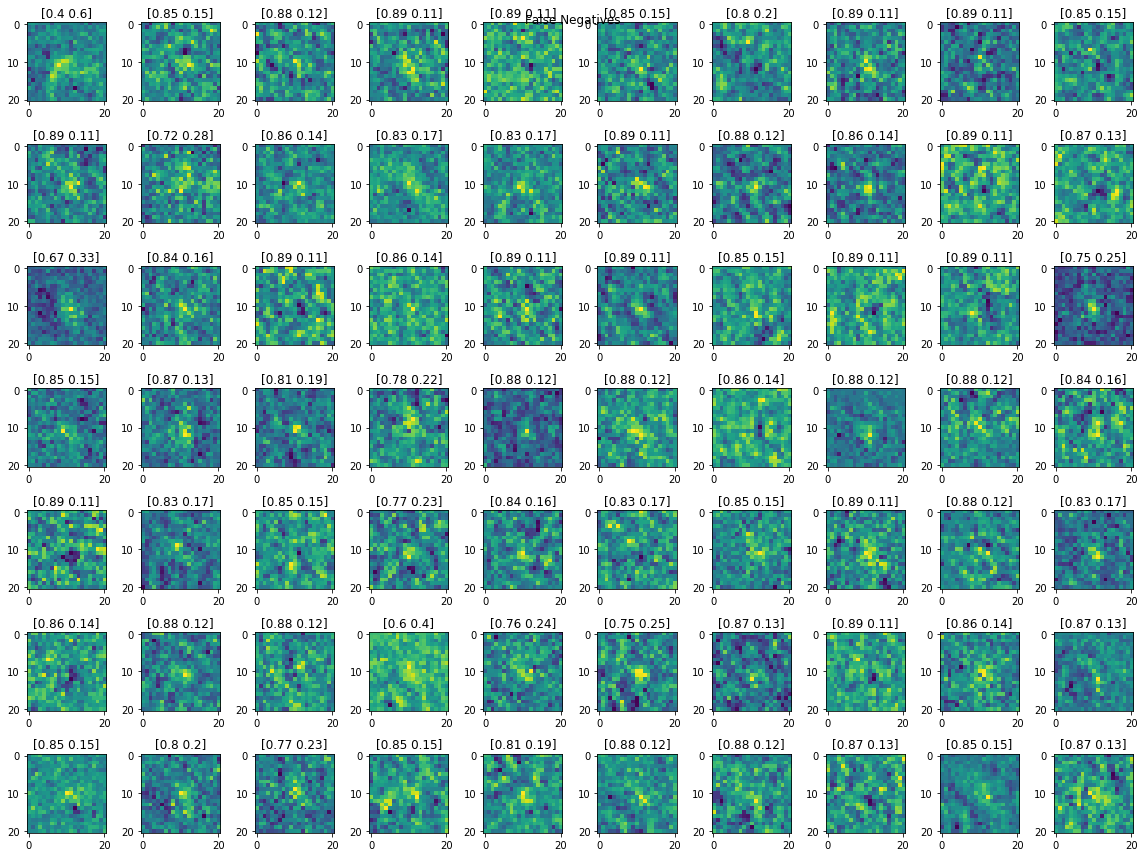

In [414]:
fig = plt.figure(figsize=(16, 12))
for i in range(70):
    fig.add_subplot(7, 10, i+1)
    plt.imshow(test_set[false_positive[i]].reshape(21,21))
    plt.title(test_probs[false_positive[i]])
plt.suptitle('False Negatives')
plt.tight_layout()

## Save Model

In [415]:
import pickle

In [416]:
filename = 'rfc_kbmod.model'
pickle.dump(rfc_kbmod, open(filename, 'wb'))